In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# figure aesthetics
plt.style.use('ggplot')
sns.set_context('talk')
sns.set_style({'axes.spines.right': False,
             'axes.spines.top': False,
             'axes.edgecolor': 'black'})

# Importing and cleaning data

In [3]:
df = pd.read_csv('./data/KaggleV2-May-2016.csv')

In [4]:
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


Let's rename a couple of columns.

In [5]:
df.rename(columns={'Handcap' : 'Handicap', 'Neighbourhood' : 'Neighborhood'}, inplace=True)

The PatientId column should probably be an integer number.

In [6]:
df['PatientId'] = df['PatientId'].astype(int)

How many patints are there?

In [7]:
df['PatientId'].nunique()

62299

Let's look at all the datatypes

In [8]:
df.dtypes

PatientId          int64
AppointmentID      int64
Gender            object
ScheduledDay      object
AppointmentDay    object
Age                int64
Neighborhood      object
Scholarship        int64
Hipertension       int64
Diabetes           int64
Alcoholism         int64
Handicap           int64
SMS_received       int64
No-show           object
dtype: object

Let's set the date columns to datetime format.

In [9]:
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'])
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'])

Now let check for nan and duplicates:

In [10]:
if ~df.duplicated().any():
    print("No duplicate rows.")

No duplicate rows.


In [11]:
if ~df.isna().any().all():
    print("No NaNs.")

No NaNs.


Finally, let's check for outliers.

In [12]:
# are genders binary?
print(df['Gender'].unique())

['F' 'M']


Text(0.5, 0, 'Age')

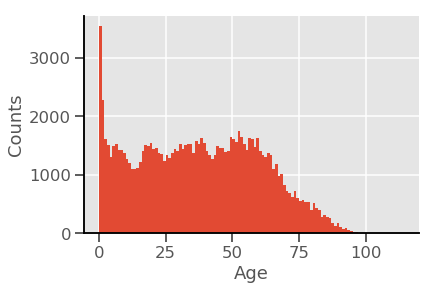

In [13]:
# what is the age distribution?
plt.hist(df['Age'], np.arange(0,115,1));
plt.ylabel('Counts')
plt.xlabel("Age")

Age distribution looks reasonble. A lot of the patients are new-borns apparently. What are the actual stats?

In [14]:
df['Age'].describe()

count    110527.000000
mean         37.088874
std          23.110205
min          -1.000000
25%          18.000000
50%          37.000000
75%          55.000000
max         115.000000
Name: Age, dtype: float64

Look's like we have a couple of outliers. The minimum patient age is -1, how many times does it happen?

In [15]:
(df['Age'] < 0).sum()

1

Let's drop it.

In [16]:
df = df.loc[df['Age'] >= 0 ]

How many patients are over 100?

In [17]:
(df['Age'] > 100).sum()

7

Only 7. Compared to around 60k patients, so I'll drop these as well.

In [18]:
df = df.loc[df['Age'] <= 100]

Let's check out the other numerical data.

In [19]:
df.select_dtypes(np.number).nunique()

PatientId         62294
AppointmentID    110519
Age                 101
Scholarship           2
Hipertension          2
Diabetes              2
Alcoholism            2
Handicap              5
SMS_received          2
dtype: int64

Looks like the other variables are binary except for Handicap.

In [20]:
df['Handicap'].unique()

array([0, 1, 2, 3, 4])

In [21]:
df['Handicap'].value_counts()

0    108282
1      2038
2       183
3        13
4         3
Name: Handicap, dtype: int64

These values could just mean different kinds or levels so I'll leave them and trust the data on this one.

In [22]:
print("There are {} different neighborhoods.".format(df.Neighborhood.nunique()))

There are 81 different neighborhoods.


# Exploring

## Time statistics

Let's create a column for the duration between scheduled day and appointment date (in days).

In [23]:
df['waitingDays'] = (df['AppointmentDay'].dt.date - df['ScheduledDay'].dt.date).dt.days

What is the range of dates?

In [24]:
print(df.AppointmentDay.apply(['min','max', lambda x: np.max(x) - np.min(x)]))

min         2016-04-29 00:00:00+00:00
max         2016-06-08 00:00:00+00:00
<lambda>             40 days 00:00:00
Name: AppointmentDay, dtype: object


In [25]:
print(df.ScheduledDay.apply(['min','max', lambda x: np.max(x) - np.min(x)]))

min         2015-11-10 07:13:56+00:00
max         2016-06-08 20:07:23+00:00
<lambda>            211 days 12:53:27
Name: ScheduledDay, dtype: object


How does waiting time correlate with showing or not showing?

In [26]:
x = df['waitingDays'].values
y = df['No-show'].map({'No':0, 'Yes':1}).values
print(f"The correlation coefficient between waiting time and no-show is {np.corrcoef(x,y)[0,1].round(2)}.")

The correlation coefficient between waiting time and no-show is 0.19.


Non-negligible but not as much as I thought. I wonder if the distance, conveyed by the neighborhood, is the main cause of someone missing their appointment. Let's also look at time of day, day of week and day of month.

To facilitate the grouping calculations, I'll define a function that returns the percentage of no-shows from a given group. This is meant to be used with `.agg` in `groupby`'s or `aggfunc` in `pivot_tables`'s.

In [27]:
def noshow_perc(x):
    """Returns percentage of no-shows when performing groupby operations."""
    return 100*(x=='Yes').sum()/len(x)

Let's look at a curve of no-show percentage by waiting days. Because the curve is noisy, especially at high values, I'll apply a rolling mean.

(0, 100)

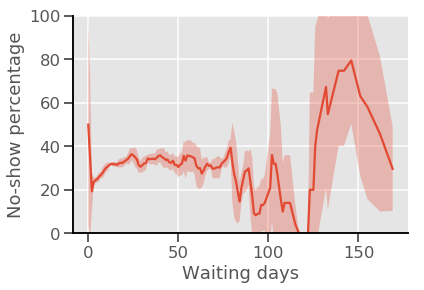

In [28]:
gdf = df.groupby('waitingDays').agg({'No-show' : noshow_perc}).rolling(5, center=True)
x = gdf.mean().index
y = gdf.mean()['No-show']
yerr = gdf.std()['No-show']

plt.plot(x,y)
plt.fill_between(x,y-yerr,y+yerr, alpha=0.3)
plt.ylabel("No-show percentage");
plt.xlabel('Waiting days')
plt.ylim(0,100)

The band shows the uncertainty of the rolling mean. Clearly there's a big spike in no-shows when the appointment and scheduling are too far apart. Let's move on to weekdays.

In [29]:
# for reordering - no appointments on Sundays
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

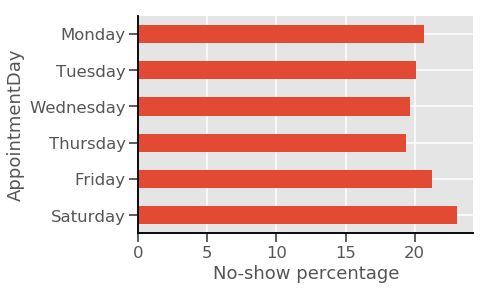

In [30]:
# grouping by weekday, calculating percentage of no-shows and plotting
# a horizontal bar chart.
df.groupby(df['AppointmentDay'].dt.weekday_name).agg(
    {'No-show':noshow_perc}
    ).loc[weekdays[::-1]].plot.barh(legend=False);
plt.xlabel('No-show percentage');

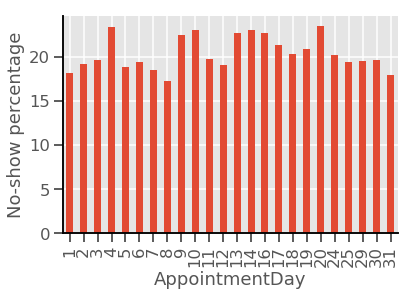

In [31]:
# grouping by day of month, calculating percentage of no-shows and plotting
# a vertical bar chart.
df.groupby(df['AppointmentDay'].dt.day).agg(
    {'No-show':noshow_perc}
    ).plot.bar(legend=False);
plt.ylabel('No-show percentage');

Unfortunately there is no appointment hour data, which I bet would correlated with no-shows. There is Scheduling hour though, so let's look at the Scheduling data.

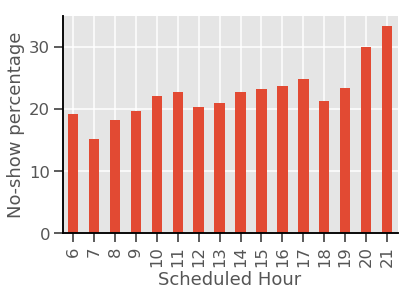

In [32]:
# grouping by day of month, calculating percentage of no-shows and plotting
# a vertical bar chart.
df.groupby(df['ScheduledDay'].dt.hour).agg(
    {'No-show':noshow_perc}
    ).plot.bar(legend=False);
plt.xlabel('Scheduled Hour')
plt.ylabel('No-show percentage');

Interestingly, the time someone made the appointment (not the appointment time) seems to correlated with no-show percentage. The correlation coefficient calculated below doesn't really convey it.

In [33]:
np.corrcoef(df.ScheduledDay.dt.hour, df['No-show'].map({'Yes':1,'No':0}))[0,1]

0.06068797817069846

### Neighborhoods with the most no-show

We can quickly look at noshow percentage as a function of neighborhood.

In [34]:
df.groupby('Neighborhood').agg({'No-show': noshow_perc}).sort_values('No-show', ascending=False).head(10)

,No-show
Neighborhood,
ILHAS OCEÂNICAS DE TRINDADE,100.000000
SANTOS DUMONT,28.918495
SANTA CECÍLIA,27.455357
SANTA CLARA,26.482213
ITARARÉ,26.266363
JESUS DE NAZARETH,24.395373
HORTO,24.000000
ILHA DO PRÍNCIPE,23.477493
CARATOÍRA,23.040936


The distribution for average number of no-shows/neighborhood is shown bellow. Looks fairly Gaussian so the fluctuations could be due to noise. I wouldn't read too much into it since each group (neighborhood) has a different number of samples (appointments).

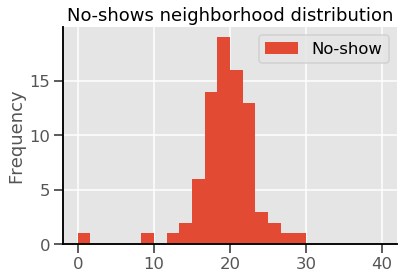

In [35]:
plt.title('No-shows neighborhood distribution')
ax = plt.gca()
df.groupby('Neighborhood').agg({'No-show': noshow_perc}
                              ).plot.hist(bins=np.linspace(0,40,25),ax=ax);

### Let's go ahed and look at stats for other groups.
First we group by age and gender with a pivot table, calculate the no-show percentage, apply a rolling mean to clean up the plot and then execute the plotting method.

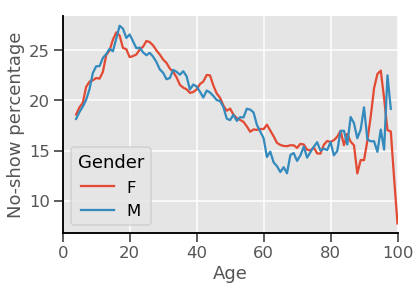

In [36]:
ax = df.pivot_table(index='Age', columns='Gender', values='No-show', aggfunc=noshow_perc).rolling(5).mean().plot()
ax.set_ylabel('No-show percentage');

There doesn't seem to be an appreciable difference by gender. The age curve seems fairly well defined, though. People around 18 years old tend to miss appointments the most while people around 65 the least.

We can keep looking at these curves, but I'll let the machine lerning output inform us on the important features. For now, let's look at the correlation between every numerical variable and no-show.

In [37]:
df['Gender'] = df['Gender'].map({'M':1,'F':0})
df['No-show'] = df['No-show'].map({'Yes':1,'No':0})

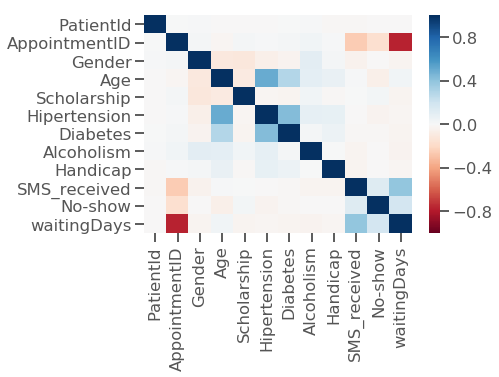

In [38]:
sns.heatmap(df.corr(),vmin=-1,vmax=1,cmap='RdBu');

There some interesting bits in this correlation matrix:
 - waitingDays and AppointmentID are anticorrelated, which suggests IDS are given chronologically
 - No-show is anti-correlated with age, hipertension and positively correlated with SMS and waiting days
 - Age, Hipertension and Diabetes are all correlated

# Preparing data for training

Before we feed this into a classifier we need to do a bit of feature engineering.

In [39]:
data = df.copy() # assign to new df

In [40]:
# drop patient ID since it's not correlated with anything
data.drop('PatientId', 1, inplace=True)

In [41]:
# get time information from dates
def add_date_info(df, datecol, hour=False):
    # add columns to dataframe df with split up date information
    datetime = df[datecol].dt
    # assign columns to dataframe
    df[datecol + '_month'] = datetime.month
    df[datecol + '_week'] = datetime.week
    df[datecol + '_dayofmonth'] = datetime.day
    df[datecol + '_dayofyear'] = datetime.dayofyear
    df[datecol + '_dayofweek'] = datetime.dayofweek
    # there is hour info for scheduledday
    if hour:
        df[datecol+'_hour'] = datetime.hour
    # drop datetime column
    df.drop(datecol,1,inplace=True)
    return df

In [42]:
data = add_date_info(data, 'AppointmentDay')
data = add_date_info(data, 'ScheduledDay', True)

In [43]:
# Do one-hot-enconding on the Neighborhood column
data = pd.concat([data, pd.get_dummies(data['Neighborhood'],prefix='N')], axis=1)
data.drop('Neighborhood',1,inplace=True)

In [44]:
# check if every column is numeric
if (data.select_dtypes(np.number).columns == data.columns).all():
    print("Every column is numeric.")

Every column is numeric.


# Logistic regression: benchmark results

Before doing any optmization, let's look at basic results from using Logistic Regression.

In [71]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
from sklearn.metrics import classification_report, precision_recall_curve, fbeta_score

In [46]:
X = data
y = X.pop('No-show')

In [47]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

## What Not To Do
Naively we could just call the classifier on our training data and look at the accuracy score. But that has two problems associated with it:
1. We need to check for class imbalance and if that affects our results.
2. Accuracy score is not ideal for binary classification. We should look at things like the confusion matrix, roc curve, auc score, precision, recall..

Let's see how broken the result is if we only look at accuracy and ignore balance.

In [48]:
# define classifier and solver
clf = LogisticRegression(solver='lbfgs', n_jobs=-1)

In [49]:
# get cross_val score
cross_val_score(clf, X_train, y_train, cv=5)

array([0.79797434, 0.79797434, 0.7979607 , 0.7979607 , 0.7979607 ])

In [50]:
# fit and get score based on y_test
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

0.7983110331212986


Out of the box we're getting 80% accuracy already. Being able to predict very accurately is very useful to prevent no-shows. However, we should check class balance before we celebrate.

In [51]:
# How many of the results are shows?
print((y_test==0).sum()/y_test.size)

0.7983110331212986


Eighty percent of the results are shows. Are we only predicting shows?

In [52]:
y_pred = clf.predict(X_test)

In [53]:
(y_pred == 0).all()

True

**YES! THE CLASSIFIER IS JUST PREDICTING "SHOWS" FOR EVERY INSTANCE**

The confusion matrix should show that too.

In [54]:
labels = ['Show', 'No-Show']
pd.DataFrame(confusion_matrix(y_test, y_pred), index=labels, columns=labels)

,Show,No-Show
Show,29116,0
No-Show,7356,0


And there it is, only the first column (prediction) has values. Instead of accuracy score, we should get the roc-auc score. That way we can see how we do as we change the threshold of the prediction.

In [55]:
def plot_roc_curve(clf, X, y_true):
    """Plots roc curve from classifier X, y_true"""
    # getting probably of no shows
    y_score = clf.predict_proba(X)[:,1]
    score = roc_auc_score(y_true,y_score)
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    fig, ax = plt.subplots(1,1, figsize=(5,5))
    ax.plot(fpr,tpr, label='ROC AUC = {:.2f}'.format(score))
    ax.plot([0,1],[0,1],'k--')
    ax.set_ylabel('TPR')
    ax.set_xlabel('FPR')
    ax.legend()
    return ax

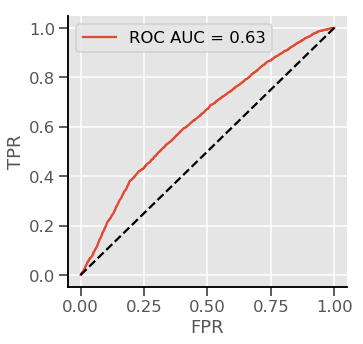

In [56]:
ax = plot_roc_curve(clf, X_test, y_test)

There it is. The score is above 0.5, meaning we're not just randomly guessing. Can we improve that by taking class imbalance into consideration?

## Class balance

The LogisticRegression classifier comes with a `class_weight` variable. That variable allows us to "balance" classes by applying appropriate weights.
>The "balanced" mode uses the values of y to automatically adjust
    weights inversely proportional to class frequencies in the input data
    as 
    ``n_samples / (n_classes * np.bincount(y))``

In [57]:
clf = LogisticRegression(solver='lbfgs', class_weight='balanced', n_jobs=-1)

Notice now that the accuracy score will drop.

In [58]:
cross_val_score(clf, X_train, y_train, cv=5)

array([0.66144497, 0.67386901, 0.66284016, 0.66493349, 0.66662165])

In [59]:
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

0.6696644000877385


That's fine because now we're predicting for both classes:

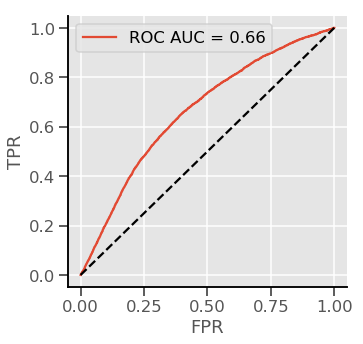

In [60]:
plot_roc_curve(clf, X_test, y_test)

And now we get a better ROC AUC score as well. However, as we can see from the table below, the recall is pretty bad. Only 50% of the no-shows were tagged correctly. If the objective is to maxime the predition of no-shows, so that can be prevented, we might want to lower the threshold.

In [91]:
def cm(X_test, y_test):
    """Returns Confusion Matrix as a pandas DataFrame"""
    labels = ['Show', 'No-Show']
    y_pred = clf.predict(X_test)
    cm = pd.DataFrame(confusion_matrix(y_test, y_pred), index=labels, columns=labels)
    return cm

def cr(X_test, y_test):
    """Returns Classification Report as pandas DataFrame"""
    return pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).T

In [90]:
cm(X_test, y_test)

,Show,No-Show
Show,20429,8687
No-Show,3361,3995


In [92]:
cr(X_test, y_test)

,f1-score,precision,recall,support
0,0.885825,0.822425,0.959816,29116.0
1,0.268481,0.530498,0.179717,7356.0
micro avg,0.802479,0.802479,0.802479,36472.0
macro avg,0.577153,0.676461,0.569767,36472.0
weighted avg,0.761313,0.763546,0.802479,36472.0


### Precision-Recall curve
Looking at this curve we can see how precision and recall vary as we change the threshold.

In [63]:
def plot_pr_curve(clf, X, y_true):
    """Plots roc curve from classifier X, y_true"""
    # getting probably of no shows
    y_proba = clf.predict_proba(X_test)[:,1]
    pr, rc, thr = precision_recall_curve(y_true, y_proba)
    fig, ax = plt.subplots(1,1, figsize=(7,5))
    ax.plot(thr, rc[:-1], label='recall')
    ax.plot(thr, pr[:-1], label='precision')
    ax.set_xlabel('Threshold')
    ax.legend()
    return ax

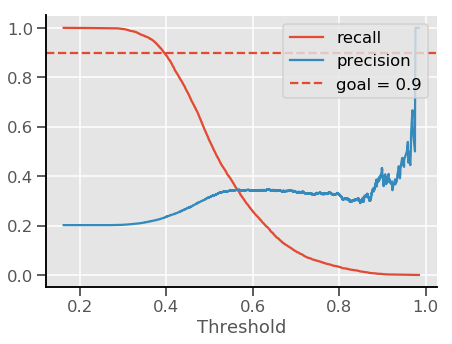

In [77]:
ax = plot_pr_curve(clf, X_test, y_test)
ax.axhline(y=0.9,ls='dashed', color='C0', label='goal = 0.9')
ax.legend()

In [65]:
pr, rc, thr = precision_recall_curve(y_test, clf.predict_proba(X_test)[:,1])

In [66]:
thr[np.argmin(np.abs(rc - 0.9))]

0.3946109150213451

In [67]:
clf.classes_

array([0, 1])

To get a recall of 0.9, we need a threshold of around 0.4.

In [78]:
y_pred = clf.predict_proba(X_test)[:,1]
y_pred[y_pred > 0.4] = 1
y_pred[y_pred <= 0.4] = 0

In [93]:
cm(X_test, y_test)

,Show,No-Show
Show,20429,8687
No-Show,3361,3995


In [94]:
cr(X_test, y_test)

,f1-score,precision,recall,support
0,0.885825,0.822425,0.959816,29116.0
1,0.268481,0.530498,0.179717,7356.0
micro avg,0.802479,0.802479,0.802479,36472.0
macro avg,0.577153,0.676461,0.569767,36472.0
weighted avg,0.761313,0.763546,0.802479,36472.0


After making those changes, we get an f1-score of 0.37. We might want to use an F score the weights recall more heavily, such as the F2 score.

In [81]:
fbeta_score(y_test, y_pred,2)

0.5714160762704453

# Feature importance and selection

In [96]:
from sklearn.ensemble import RandomForestClassifier

In [97]:
rf = RandomForestClassifier(100, n_jobs=-1)

In [98]:
cross_val_score(rf, X_test, y_test, cv =5)

array([0.79646382, 0.7966822 , 0.79380313, 0.7975048 , 0.7969564 ])

In [99]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [100]:
y_pred = rf.predict(X_test)

In [101]:
cm(X_test, y_test)

,Show,No-Show
Show,20429,8687
No-Show,3361,3995


In [102]:
cr(X_test, y_test)

,f1-score,precision,recall,support
0,0.885791,0.822014,0.960297,29116.0
1,0.265335,0.529699,0.176998,7356.0
micro avg,0.802314,0.802314,0.802314,36472.0
macro avg,0.575563,0.675857,0.568648,36472.0
weighted avg,0.760652,0.763058,0.802314,36472.0


In [111]:
X.columns[~X.columns.str.startswith('N_')]

Index(['AppointmentID', 'Gender', 'Age', 'Scholarship', 'Hipertension',
       'Diabetes', 'Alcoholism', 'Handicap', 'SMS_received', 'waitingDays',
       'AppointmentDay_month', 'AppointmentDay_week',
       'AppointmentDay_dayofmonth', 'AppointmentDay_dayofyear',
       'AppointmentDay_dayofweek', 'ScheduledDay_month', 'ScheduledDay_week',
       'ScheduledDay_dayofmonth', 'ScheduledDay_dayofyear',
       'ScheduledDay_dayofweek', 'ScheduledDay_hour'],
      dtype='object')

In [112]:
rf.feature_importances_

array([1.59395606e-01, 2.54170327e-02, 1.36624760e-01, 1.14397245e-02,
       1.10355497e-02, 7.69581636e-03, 5.56163603e-03, 4.72793943e-03,
       1.23109185e-02, 8.24111039e-02, 3.62905649e-03, 1.27196194e-02,
       3.15773601e-02, 3.23570131e-02, 2.44985461e-02, 8.84043665e-03,
       1.53363631e-02, 2.85489242e-02, 3.24381078e-02, 2.22062014e-02,
       7.95854698e-02, 2.55371039e-05, 5.48142287e-03, 1.06951433e-03,
       1.26661318e-03, 1.54958402e-03, 4.48025713e-03, 3.02373741e-03,
       1.03450969e-03, 6.06169797e-03, 5.74071525e-03, 6.94694836e-03,
       9.08248848e-04, 2.66740412e-03, 3.49338351e-03, 3.78339037e-03,
       5.02367693e-03, 9.29039346e-04, 1.57652167e-03, 1.39237216e-03,
       2.34029582e-03, 1.01090198e-03, 2.17675579e-03, 2.37983313e-03,
       4.51375631e-03, 9.46799531e-04, 2.48176878e-03, 3.22828944e-03,
       4.64362374e-03, 8.21846662e-04, 3.01050840e-03, 4.13293781e-03,
       1.03011595e-04, 5.11972326e-06, 5.11220061e-03, 5.28855356e-05,
      